# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Jesper Ekstrøm"
STUDENT_1_STUDENT_NUMBER = "5900468"
STUDENT_1_NETID = "jekstrom"
STUDENT_1_EMAIL = "J.Ekstrom@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2a.1 - PD control (2p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import numpy as jnp
import os
from pathlib import Path

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

## Implementing `ctrl_fb_pd` (0.5p)
Please implement a basic PD controller into the function `ctrl_fb_pd` in the notebook `controllers.ipynb`. It shall regulate the link angles and angular velocities $\theta \in \mathbb{R}^2$, $\dot{\theta} \in \mathbb{R}^2$ towards the desired trajectory $\theta^\mathrm{d} \in \mathbb{R}^2$, $\dot{\theta}^\mathrm{d} \in \mathbb{R}^2$. The resulting control law is given by:

\begin{equation}
\tau_\mathrm{fb} = k_\mathrm{p} \, (\theta^\mathrm{d}-\theta) + k_\mathrm{d} \, (\dot{\theta}^\mathrm{d}-\dot{\theta})
\end{equation}


In [4]:
# DO NOT REMOVE OR MODIFY THIS CELL

# import feedback controller from controllers.ipynb
from ipynb.fs.full.controllers import ctrl_fb_pd

# test output shape of ctr_fb_pd
_tau_dummy = ctrl_fb_pd(
    jnp.ones((2,)),
    jnp.ones((2,)),
    jnp.zeros((2,)),
    jnp.zeros((2,)),
    kp=jnp.eye(2),
    kd=jnp.eye(2),
)
print("Computed torque:", _tau_dummy, "Nm")
assert _tau_dummy.shape == (2,), "The computed torque needs to be of shape (2, )"


Computed torque: [-2. -2.] Nm


## Simulating the closed-loop system (1.5p)

In this section, we apply the implemented PD controller to a closed-loop simulation. The goal is achieve an RMSE error for the end-effector position of just lower than 0.075m. Please tune the gain matrices `kp` and `kd` accordingly.

In [5]:
from jax_double_pendulum.analysis import *
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

# simulation parameters
sim_duration = 10.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# initial link angles (i.e. at the first time-step)
th_0 = traj_ts["th_ts"][0] - jnp.array([0.1, 0.2])

In [6]:
# controller parameters
# define the proportional gain matrix kp and the derivative gain matrix kd

# YOUR CODE HERE
kp = jnp.array([[3500, 0],
                [0, 3500]]) 
kd = jnp.array([[3300, 0],
                [0, 100]]) 
# GOOD ENOUGH VALUES
# kp = jnp.array([[2500, 0],
#                 [0, 1200]]) 
# kd = jnp.array([[3300, 0],
#                 [0, 100]]) 

Now, we simulate the robot for 10s and save the states and inputs throughout the simulation in the `sim_ts` dictionary. **Please make sure to study the usage and behaviour of the `partial` function, as it will be very relevant and often-used throughout the entire assignment.** You can find a nice tutorial for example [here](https://www.pythontutorial.net/python-basics/python-partial-functions/).

In [7]:
# simulate the robot with the given controller
sim_ts = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=traj_ts["th_d_ts"][0],
    th_des_ts=traj_ts["th_ts"],
    th_d_des_ts=traj_ts["th_d_ts"],
    th_dd_des_ts=traj_ts["th_dd_ts"],
    ctrl_ff=lambda _th, _th_d, _th_des, _th_d_des, _th_dd_des: jnp.zeros((2,)),
    ctrl_fb=partial(ctrl_fb_pd, kp=kp, kd=kd),
)

# evaluate the control performance quantitatively
rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(traj_ts, sim_ts)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(traj_ts, sim_ts)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.034 0.021] rad, RMSE theta_d: [0.044 0.297] rad/s, RMSE theta_dd: [0.264 9.993] rad/s^2
RMSE x: 0.0657 m, RMSE x_d: 0.323 m/s, RMSE x_dd: 10.12 m/s^2


In [8]:
# DO NOT REMOVE OR MODIFY THIS CELL


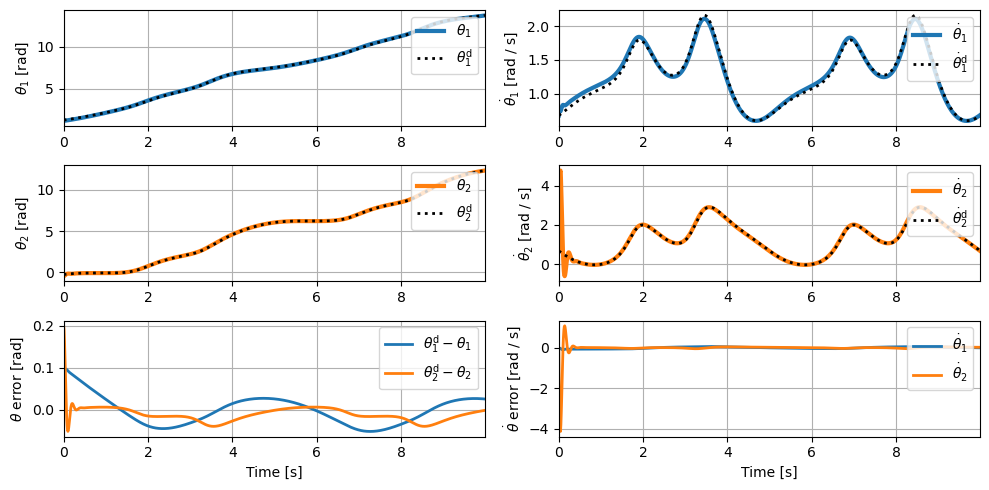

In [9]:
# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# plot the configuration-space evolution
plot_configuration_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(
        outputs_dir / "task_2a-1_configuration_space_trajectory_following.pdf"
    ),
)

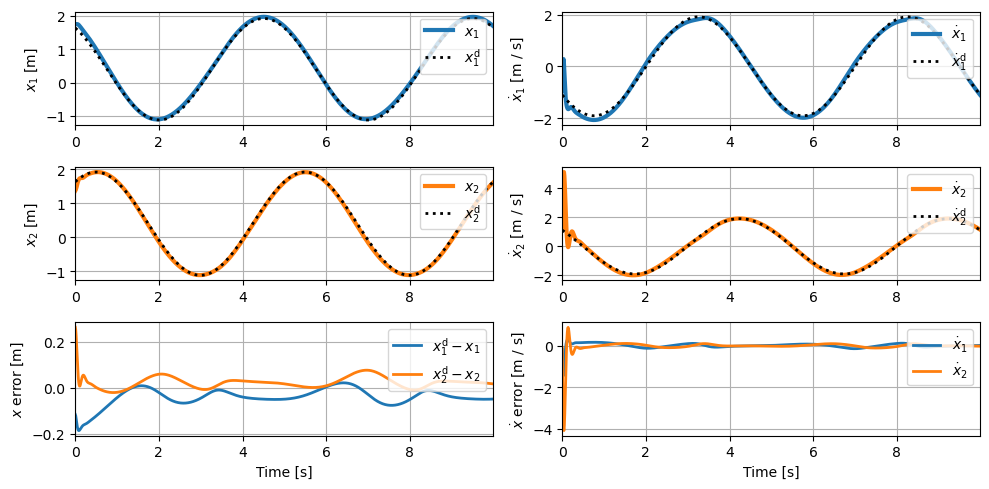

In [10]:
# plot the operational-space evolution
plot_operational_space_trajectory_following(
    traj_ts,
    sim_ts,
    filepath=str(outputs_dir / "task_2a-1_operational_space_trajectory_following.pdf"),
)

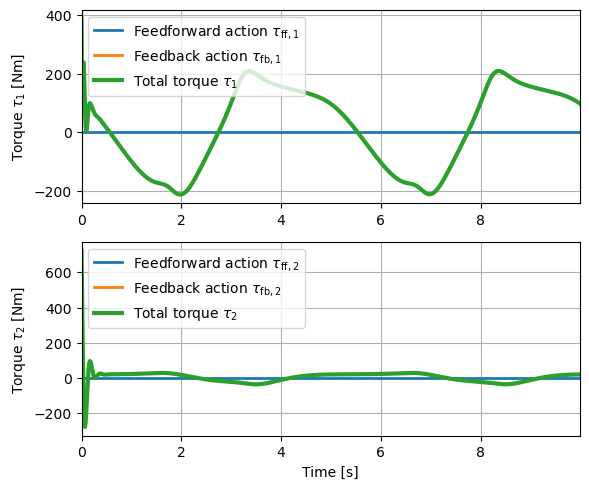

In [11]:
# plot the actuation sequence
plot_actuation(sim_ts, filepath=str(outputs_dir / "task_2a-1_actuation.pdf"))

In [12]:
if not AUTOGRADING:
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2a-1_controlled_robot.mp4"),
    )
    display(HTML(ani.to_html5_video()))